In [2]:
import numpy as np
import sktensor
import tensorly
import scipy
from tensorly import fold
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import imageio
from PIL import Image
from tensorly.decomposition import tucker
from tensorly import unfold
from skimage import data
from skimage import img_as_ubyte,img_as_float
from ipywidgets import interact,interactive,interact_manual
import pandas as pd

Using numpy backend.


In [3]:
def calcEigenvalues(tensore, mode):
    li = []
    matr = unfold(tensore, mode)
    for i in range(matr.shape[0]):
        su = 0
        for j in range(matr.shape[1]):
            su = su + (matr[i, j]**2)
        li.append(su**0.5)
    return np.array(li)

def zeroedModeRow(tensore, mode, row):
    original_shape = tensore.shape
    unfolded = unfold(tensore, mode)
    for j in range(unfolded.shape[1]):
        unfolded[row, j] = 0
    return fold(unfolded, mode, original_shape)

def findIthMinimumIdexs(matrix, ith):
    min_i, min_j = 0, 0
    tuples_indexes_list = []
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            tuples_indexes_list.append((matrix[i][j], i, j))
    tuples_indexes_list.sort(key = lambda el : el[0])
    if len(tuples_indexes_list) > ith:
        return (tuples_indexes_list[ith][1], tuples_indexes_list[ith][2])
    else:
        return None


def tensorRanksEigenvalues(tensor) :
    a = []
    for i in range(len(tensor.shape)):
        a.append(calcEigenvalues(tensor, i))
    return np.array(a)

def reduceTensorValues(tensor, ith):
    eigenvalue = tensorRanksEigenvalues(tensor)
    
    for i in range(ith):
        indexes = findIthMinimumIdexs(eigenvalue, i)
        if indexes != None:
            tensor = zeroedModeRow(tensor, indexes[0], indexes[1])
    return tensor

def reduceTensors(tensor, k):
    S, U = tucker(tensor, tensor.shape)
    eigenvalue = tensorRanksEigenvalues(S)
    
    tupleForSubstraction = list(S.shape)
    for i in range(k):
        indexes = findIthMinimumIdexs(eigenvalue, i)
        if indexes != None and tupleForSubstraction[indexes[0]] != 1:
            tupleForSubstraction[indexes[0]] -= 1
    return tucker(tensor, tuple(tupleForSubstraction))


In [29]:
def imageToTensor(image):
    r = np.full(image.size, 0)
    g = np.full(image.size, 0)
    b = np.full(image.size, 0)
    pix = image.load()
    for i in range(image.size[0]):
        for j in range(image.size[1]):
            r[i, j] = pix[i, j][0]
            g[i, j] = pix[i, j][1]
            b[i, j] = pix[i, j][2]
    imageTensor = np.array([r, g, b])
    return imageTensor.astype(float)

def tensorToImage(tensor):
    shape = tensor.shape
    imgConv = np.full((shape[1], shape[2], 3), (0, 0, 0))
    for i in range(shape[1]):
        for j in range(shape[2]):
            imgConv[i, j] = (tensor[0, i, j], tensor[1, i, j], tensor[2, i, j])
    return np.array(imgConv)

def restoreTensor(S, U):
    R = tensorly.tenalg.mode_dot(S, U[0], 0)
    for i in range(1, len(U)):
        R = tensorly.tenalg.mode_dot(R, U[i], i)
    return R

def calcTensorSize(tensor):
    shape = tensor.shape
    size = shape[0]
    for i in range(1, len(shape)):
        size *= shape[i]
    return size

def calcSize(S, U):
    size  = calcTensorSize(S)
    for i in range(len(U)):
        ush = U[i].shape
        size += ush[0]*ush[1]
    return size


def calcDistanceAndCompression(im, k):
    imageTensore = imageToTensor(im)
    originalSize = calcTensorSize(imageTensore)
    
    S, U = reduceTensors(imageTensore, k)
    reducedImageTensor = restoreTensor(S, U)
    reducedImage = tensorToImage(reducedImageTensor)
    compressedSize = calcSize(S, U)
    
    dist = np.linalg.norm(imageTensore) - np.linalg.norm(reducedImageTensor)
    compressionRatio =100.0*(compressedSize/originalSize)
    
    return (dist, compressionRatio, reducedImage)

def printImageUsingTensor(tensor, label = ''):  
    fig,axes = plt.subplots(figsize=(8, 16))
    axes.set_title(label)
    axes.set_axis_off()
    axes.imshow(np.asarray(tensor))



In [47]:
def compress_svd(image,k):
    U,s,V = np.linalg.svd(image, full_matrices=False)
    reconst_matrix = np.dot(U[:,:k], np.dot(np.diag(s[:k]), V[:k,:]))
    return reconst_matrix,s

def compress_show_color_images_reshape(image,k):
    original_shape = image.shape
    image_reshaped = image.reshape((original_shape[1],original_shape[2]*3))
    image_reconst,_ = compress_svd(image_reshaped,k)
    image_reconst = image_reconst.reshape(original_shape)
    compression_ratio =100.0* (k*(original_shape[0] + 3*original_shape[1])+k)/(original_shape[0]*original_shape[1]*original_shape[2])
    distance = np.linalg.norm(image) - np.linalg.norm(image_reconst)
    return (distance, compression_ratio, tensorToImage(image_reconst))


In [6]:
im2 = Image.open('./photo example.jpg')
dist = []
com = []
for i in range(0, 3000, 50):
    d, c, compressedImage = calcDistanceAndCompression(im2, i)
    dist.append(d)
    com.append(c)

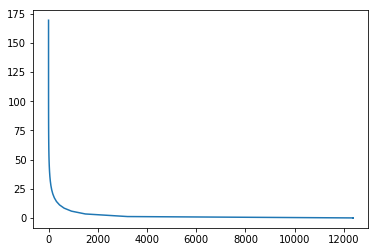

In [7]:
plt.plot(dist, com)
plt.show()

In [11]:
distSvd = []
comSvd = []
for i in range(0, 2000, 25):
    d, c, image = compress_show_color_images_reshape(imageToTensor(im2), i)
    distSvd.append(d)
    comSvd.append(c)


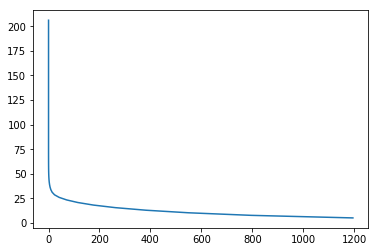

In [12]:
plt.plot(distSvd[2:], comSvd[2:])
plt.show()

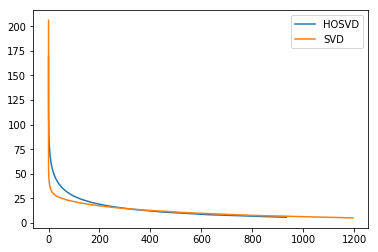

In [15]:
plt.plot(dist[:-28], com[:-28], label='HOSVD')
plt.plot(distSvd[2:], comSvd[2:], label='SVD')
plt.legend(loc='upper right')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


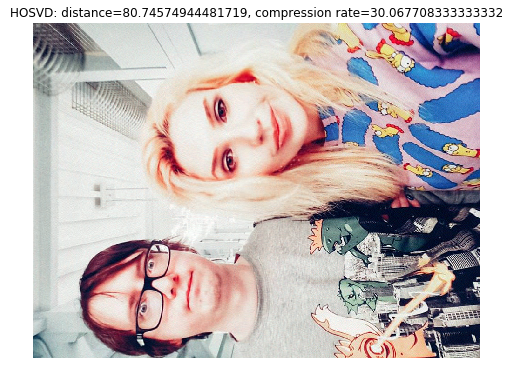

In [44]:
(d, c, image) = calcDistanceAndCompression(im2, 1170)
printImageUsingTensor(image, 'HOSVD: distance='+str(d)+', compression rate='+str(c))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


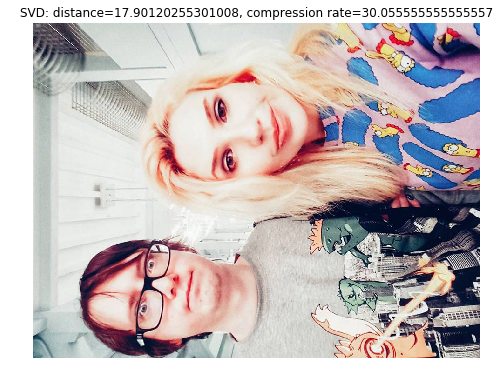

In [52]:
(d, c, image) = compress_show_color_images_reshape(imageToTensor(im2), 288)
printImageUsingTensor(image, 'SVD: distance='+str(d)+', compression rate='+str(c))

In [16]:
im3 = Image.open('./photo for tests.jpg')

In [17]:
distSvd2 = []
comSvd2 = []
for i in range(0, 2000, 25):
    d, c, image = compress_show_color_images_reshape(imageToTensor(im3), i)
    distSvd2.append(d)
    comSvd2.append(c)

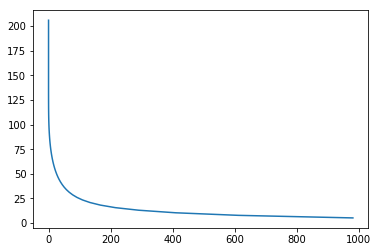

In [19]:
plt.plot(distSvd2[2:], comSvd2[2:])
plt.show()

In [20]:
dist2 = []
com2 = []
for i in range(0, 3000, 50):
    d, c, compressedImage = calcDistanceAndCompression(im3, i)
    dist2.append(d)
    com2.append(c)


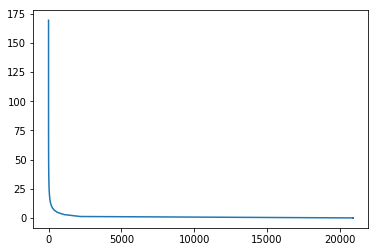

In [21]:
plt.plot(dist2, com2)
plt.show()

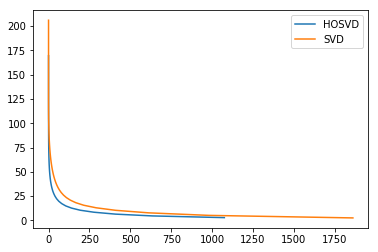

In [22]:
plt.plot(dist2[:44], com2[:44], label='HOSVD')
plt.plot(distSvd2[1:], comSvd2[1:], label='SVD')
plt.legend(loc='upper right')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


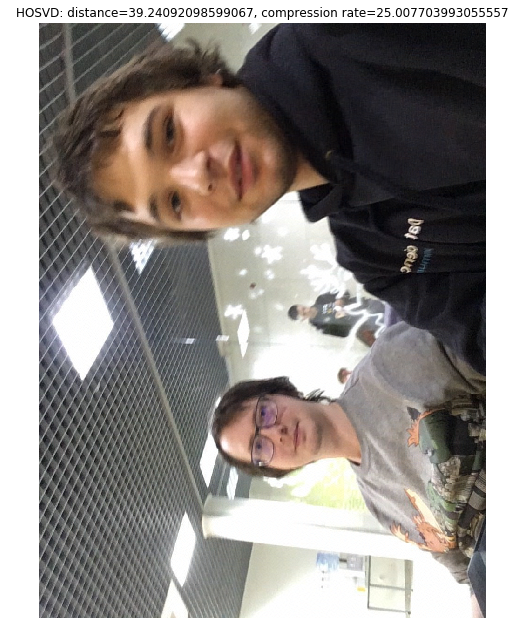

In [65]:
(d, c, image) = calcDistanceAndCompression(im3, 1650)
printImageUsingTensor(image, 'HOSVD: distance='+str(d)+', compression rate='+str(c))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


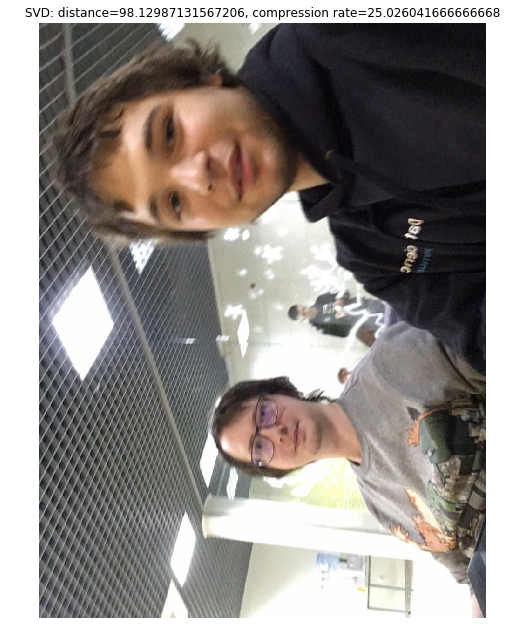

In [68]:
(d, c, image) = compress_show_color_images_reshape(imageToTensor(im3), 240)
printImageUsingTensor(image, 'SVD: distance='+str(d)+', compression rate='+str(c))